The nonlinear Lorenz system:
\begin{equation}
\begin{aligned}
&\dot x = \sigma(y-x),\\
&\dot y = x(\rho - z) - y,\\
&\dot z = xy - \beta z.
\end{aligned}    
\end{equation}

In [36]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
import numpy as np
from ocn import *

plt.rcParams.update({'font.size': 12})

import argparse
import torch.nn as nn
from torch_symplectic_adjoint import odeint_symplectic_adjoint as odeint
from mpl_toolkits import mplot3d

In [2]:
def get_curve_data(pretrained=True, dataset='cifar10', model='', optim=''):
    folder_path = 'curve'
    if pretrained:
        folder_path = os.path.join(folder_path, 'pretrained')
        
    filenames = [name for name in os.listdir(folder_path) 
                 if dataset in name #name.startswith('-'.join([dataset,model,optim]))]
                 and model in name
                 and optim in name]
    keys = [name for name in filenames]
    paths = [os.path.join(folder_path, name) for name in filenames]
    return {key: torch.load(fp, map_location='cpu') for key, fp in zip(keys, paths)}

def plot(pretrained=False, dataset='cifar10', model='', optim='', curve_type='train',idx=0, ylim=[60,95]):
    
    curve_data = get_curve_data(pretrained, dataset=dataset, model=model, optim=optim)
    curve_data_keys = curve_data.keys()

    plt.figure( figsize=(5,4))
    for key in curve_data_keys:
        curves = curve_data[key]['{}'.format(curve_type)]
        if isinstance(curves[0], (int, float)):
            plt.plot(curves, label='-'.join([key.split('-')[0], key.split('-')[-1]]))
        else:
            curve = [x[idx] for x in curves]
            plt.plot(curve, label='-'.join([key.split('-')[0], key.split('-')[-1]]))
    
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('{}'.format(curve_type))
    plt.ylim(ylim)
    plt.grid(ls='--')
    plt.legend()
    plt.tight_layout()

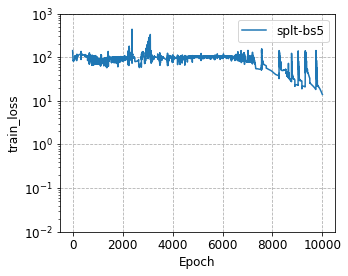

In [3]:
plot(pretrained=False, dataset='', model='T3.0-bs5', optim='', curve_type='train_loss', ylim=[0.01,1000])

# Short-time performance 
In this case, the data used to train OCN is collected from $1$ trajectory with the initial point $[10, 15, 17]$, time interval $[0,1.5]$, and time step $\Delta t=0.01$. 

After the model is well trained, we apply it to generate trajectories on time interval $[0, 3]$ with the same initial point. 

In [4]:
def get_parser():
    parser = argparse.ArgumentParser('Lorenz system')
    parser.add_argument('--hidden_layers', type=int, default=2)
    parser.add_argument('--hidden_neurons', type=int, default=300)
    parser.add_argument('--x0', nargs='+', default=[10., 15., 17.])
    parser.add_argument('--train_time', type=float, default=3)
    parser.add_argument('--train_size', type=int, default=300)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=1.5)
    parser.add_argument('--test_size', type=int, default=150)
    return parser

In [10]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

ckpt = torch.load('checkpoint/mu0-T1.5-bs2', map_location=torch.device('cpu'))
ocn = OCN()
ocn.load_state_dict(ckpt['params'])

<All keys matched successfully>

In [11]:
y0 = torch.tensor([args.x0]).to(device)
true_y_train, train_t = build_dataset(args, model_true=Lorenz, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

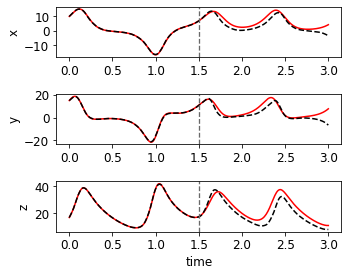

In [12]:
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(311)
ax.plot(train_tt, true_train_yy[:, 0, 0], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 0], 'k--')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel("x")

ax = fig.add_subplot(312)
ax.plot(train_tt, true_train_yy[:, 0, 1], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 1], 'k--')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel("y")

ax = fig.add_subplot(313)
ax.plot(train_tt, true_train_yy[:, 0, 2], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 2], 'k--')
ax.axvline(x=1.5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.xlabel("time")
plt.ylabel("z")

plt.tight_layout()

In [10]:
np.mean((true_train_yy-pred_train_yy)**2)

6.929658

# Long-time performance
The data used for training OCN is collected from $1$ trajectory starting from $[-8, 8, 27]$, with time interval $[0,20]$ and time step $\Delta t=0.01$. 

In [37]:
def get_parser():
    parser = argparse.ArgumentParser('Lorenz system')
    parser.add_argument('--hidden_layers', type=int, default=2)
    parser.add_argument('--hidden_neurons', type=int, default=300)
    parser.add_argument('--x0', nargs='+', default=[-8., 8., 27.])
    parser.add_argument('--train_time', type=float, default=20)
    parser.add_argument('--train_size', type=int, default=2000)
    parser.add_argument('--batch_size', type=int, default=1000)
    parser.add_argument('--test_time', type=int, default=1)
    parser.add_argument('--test_size', type=int, default=100)
    return parser

In [38]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

ckpt = torch.load('checkpoint/splt-T20.0-bs1000', map_location=torch.device('cpu'))
ocn = OCN()
ocn.load_state_dict(ckpt['params'])

<All keys matched successfully>

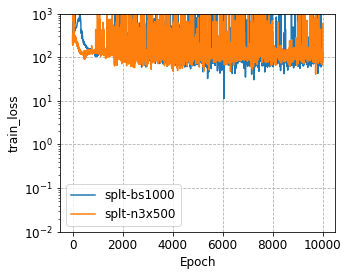

In [16]:
plot(pretrained=False, dataset='', model='splt-T20.0-bs1000', optim='', curve_type='train_loss', ylim=[0.01,1000])

In [39]:
ckpt['loss'], ckpt['epoch']

(11.250462532043457, 6049)

In [40]:
y0 = torch.tensor([args.x0]).to(device)
true_y_train, train_t = build_dataset(args, model_true=Lorenz, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

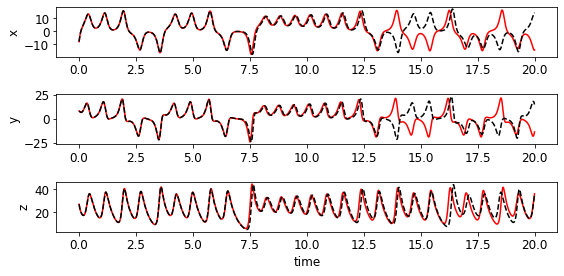

In [41]:
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(311)
ax.plot(train_tt, true_train_yy[:, 0, 0], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 0], 'k--')
plt.ylabel("x")

ax = fig.add_subplot(312)
ax.plot(train_tt, true_train_yy[:, 0, 1], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 1], 'k--')
plt.ylabel("y")

ax = fig.add_subplot(313)
ax.plot(train_tt, true_train_yy[:, 0, 2], 'r')
ax.plot(train_tt, pred_train_yy[:, 0, 2], 'k--')
plt.xlabel("time")
plt.ylabel("z")

plt.tight_layout()
# plt.savefig('output/splt_Lorenz_h2', dpi=300)

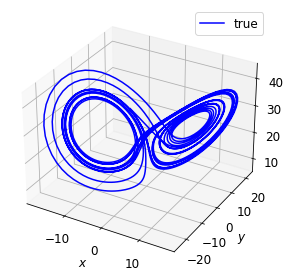

In [42]:
fig = plt.figure(1, figsize=(5,4)).add_subplot(projection='3d')
fig.plot3D(true_train_yy[:, 0, 0], true_train_yy[:, 0, 1], true_train_yy[:, 0, 2], 'b-', label = 'true')
fig.set_xlabel(r'$x$')
fig.set_ylabel(r'$y$')
fig.legend()

plt.tight_layout()
#plt.savefig('output/splt_Lorenz_3d_true', dpi=300)

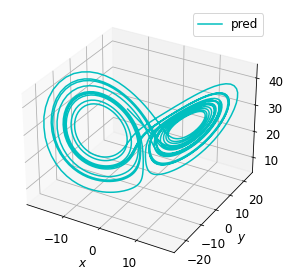

In [43]:
fig = plt.figure(1, figsize=(5,4)).add_subplot(projection='3d')
fig.plot3D(pred_train_yy[:, 0, 0], pred_train_yy[:, 0, 1], pred_train_yy[:, 0, 2], 'c-', label = 'pred')
fig.set_xlabel(r'$x$')
fig.set_ylabel(r'$y$')
fig.legend()

plt.tight_layout()
#plt.savefig('output/splt_Lorenz_3d_pred', dpi=300)

In [44]:
np.mean((true_train_yy-pred_train_yy)**2)

44.77337